# Notebook for measuring the bandwidth

Jan, Nina Horat & Laura Endres

In [33]:
#Libraries
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess
import numpy as np

In [34]:
#Name Lists
backend_list = ["gt4py",
                "cupy",
                "numba_cuda"]

## Timing
### Execute memory transfer for evaluation

In [9]:
#Parameter 
field_size_list = [16,32,64,128,512]
df_name = "bandwidth" #Name of evaluation dataframe
num_iter = 20

#timing
for size in field_size_list:
    print(size,':')
    for y in backend_list:
        bashCommand=f" python3 main_bandwidth.py --nx {size} --ny {size} --nz {size} --backend {y} --num_iter {num_iter} --df_name {df_name}"
        process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
        print('                 ',y,' calculated.')
        output, error = process.communicate()
        print(output.decode("utf-8"))

1024 :
                  gt4py  calculated.
juhuu

                  cupy  calculated.
juhuu

                  numba_cuda  calculated.
juhuu



### Read out the dataframe and plot results
The program saves the evaluation data into a pandas dataframe (Name is defined with the option --df_name). Subsequently the df can be accessed for further processing within a jupyter notebook.

## Data analysis:

In [37]:
df1= pd.read_pickle("eval/{}_result.pkl".format("bandwidth"))

#frames = [df1, df2]
df_data = df1#pd.concat(frames)

In [38]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   backend                           18 non-null     object 
 1   nx                                18 non-null     object 
 2   ny                                18 non-null     object 
 3   nz                                18 non-null     object 
 4   num_iter                          18 non-null     object 
 5   time_total                        18 non-null     float64
 6   time_avg                          18 non-null     float64
 7   time_stdev                        18 non-null     float64
 8   number_of_gbytes                  18 non-null     float64
 9   memory_bandwidth_in_gbs           18 non-null     float64
 10  memory_bandwidth_stdev            18 non-null     float64
 11  peak_bandwidth_in_gbs             18 non-null     float64
 12  fraction_o

In [6]:
df_data.head(50)

,backend,nx,ny,nz,num_iter,time_total,time_avg,time_stdev,number_of_gbytes,memory_bandwidth_in_gbs,memory_bandwidth_stdev,peak_bandwidth_in_gbs,fraction_of_peak_bandwidth,fraction_of_peak_bandwidth_stdev
0,gt4py,16,16,16,20,0.000834,0.000042,0.000010,0.000031,0.731638,3.135083,68.3,0.010712,0.045902
1,cupy,16,16,16,20,0.165244,0.008262,0.035603,0.000031,0.003694,0.000857,68.3,0.000054,0.000013
2,numba_cuda,16,16,16,20,0.088959,0.004448,0.017771,0.000031,0.006861,0.001717,68.3,0.000100,0.000025
3,gt4py,32,32,32,20,0.001177,0.000059,0.000009,0.000244,4.147428,27.962178,68.3,0.060724,0.409402
4,cupy,32,32,32,20,0.151748,0.007587,0.032635,0.000244,0.032177,0.007481,68.3,0.000471,0.000110
5,numba_cuda,32,32,32,20,0.089969,0.004498,0.017828,0.000244,0.054272,0.013694,68.3,0.000795,0.000201
6,gt4py,64,64,64,20,0.004220,0.000211,0.000011,0.001953,9.255451,180.566284,68.3,0.135512,2.643723
7,cupy,64,64,64,20,0.155211,0.007761,0.033310,0.001953,0.251673,0.058634,68.3,0.003685,0.000858
8,numba_cuda,64,64,64,20,0.096459,0.004823,0.017776,0.001953,0.404965,0.109876,68.3,0.005929,0.001609
9,gt4py,128,128,128,20,0.028475,0.001424,0.000009,0.015625,10.974429,1684.396172,68.3,0.160680,24.661730


In [102]:
#peak bandwidth
#theorethical peak bandwidth day1 jupyter 03a
f_ddr=2133*10**6
channels=4
width=64/8
peak_bandwidth_in_gbs = f_ddr*channels*width*1.e-9
print(peak_bandwidth_in_gbs)

68.256


### Average time for transferring data from CPU to GPU

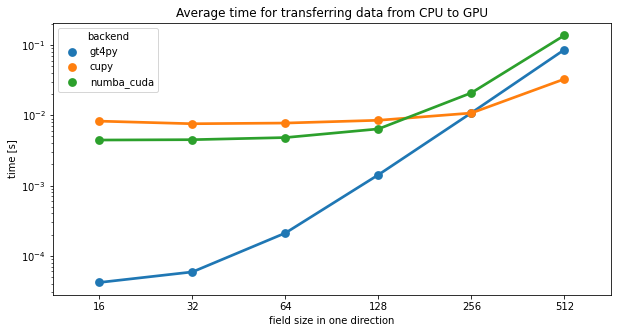

In [39]:
plt.figure(figsize=(10,5))
chart=sns.pointplot(x="nx", y="time_avg", 
                  hue="backend",
                  data=df_data,ci=False
                 )
chart.set(xlabel='field size in one direction', ylabel='time [s]')
plt.title('Average time for transferring data from CPU to GPU')
chart.set_yscale("log")

[Text(0, 0, '2^34'),
 Text(0, 0, '2^35'),
 Text(0, 0, '2^36'),
 Text(0, 0, '2^37'),
 Text(0, 0, '2^38'),
 Text(0, 0, '2^39')]

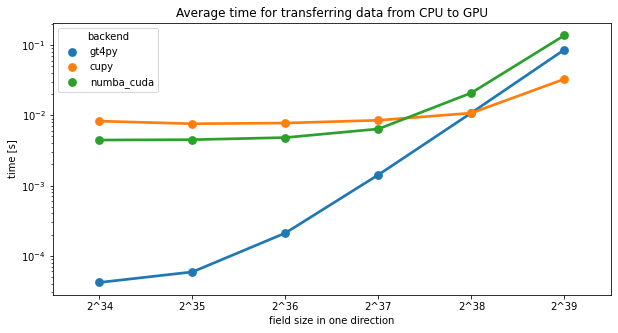

In [11]:
plt.figure(figsize=(10,5))
chart=sns.pointplot(x="number_of_gbytes", y="time_avg", 
                  hue="backend",
                  data=df_data,ci=False
                 )
chart.set(xlabel='field size [Byte]', ylabel='time [s]')
plt.title('Average time for transferring data from CPU to GPU')
chart.set_yscale("log")

texts = [t.get_text()  for t in chart.get_xticklabels()]
ticks = []
for i in texts:
    ticks.append("2^" + str(int(np.log2(float(i)*1024**3))))
chart.set_xticklabels(ticks)

### Bandwidth for data transfer from CPU to GPU

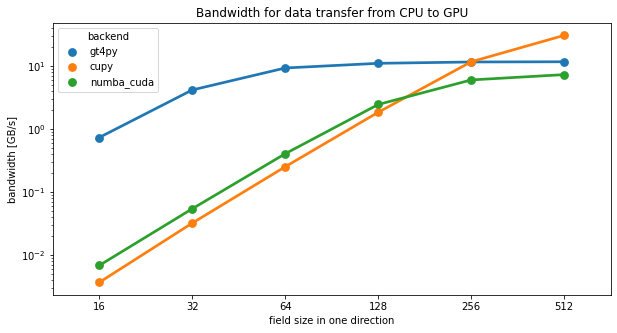

In [12]:
plt.figure(figsize=(10,5))
chart=sns.pointplot(x="nx", y="memory_bandwidth_in_gbs", 
                  hue="backend",
                  data=df_data,ci=False
                 )
chart.set(xlabel='field size in one direction', ylabel='bandwidth [GB/s]')
plt.title('Bandwidth for data transfer from CPU to GPU')
chart.set_yscale("log")

3.0517578125e-05
0.000244140625
0.001953125
0.015625
0.125
1.0


[Text(0, 0, '2^15'),
 Text(0, 0, '2^18'),
 Text(0, 0, '2^21'),
 Text(0, 0, '2^24'),
 Text(0, 0, '2^27'),
 Text(0, 0, '2^30')]

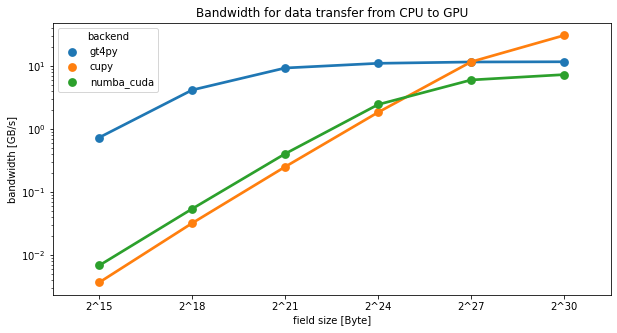

In [21]:
import matplotlib.ticker as ticker
plt.figure(figsize=(10,5))
chart=sns.pointplot(x="number_of_gbytes", y="memory_bandwidth_in_gbs", 
                  hue="backend",
                  data=df_data,ci=False
                 )
chart.set(xlabel='field size [Byte]', ylabel='bandwidth [GB/s]')
plt.title('Bandwidth for data transfer from CPU to GPU')
chart.set_yscale("log")
#chart.set_xscale("log")

texts = [t.get_text()  for t in chart.get_xticklabels()]
ticks = []
for i in texts:
    ticks.append("2^" + str(int(np.log2(float(i)*1024**3))))
chart.set_xticklabels(ticks)

### in percent of peak bandwidth

Text(0.5, 1.0, 'Bandwidth in percent of peak bandwidth')

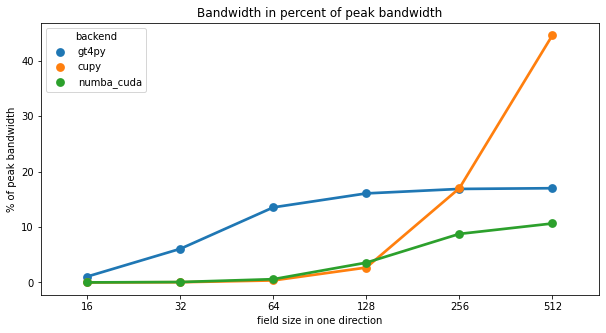

In [16]:
plt.figure(figsize=(10,5))
chart=sns.pointplot(x="nx", y=df_data.fraction_of_peak_bandwidth*100, 
                  hue="backend",
                  data=df_data,ci=False
                 )
chart.set(xlabel='field size in one direction', ylabel='% of peak bandwidth')
plt.title('Bandwidth in percent of peak bandwidth')
#chart.set_yscale("log")


3.0517578125e-05
0.000244140625
0.001953125
0.015625
0.125
1.0


[Text(0, 0, '2^15'),
 Text(0, 0, '2^18'),
 Text(0, 0, '2^21'),
 Text(0, 0, '2^24'),
 Text(0, 0, '2^27'),
 Text(0, 0, '2^30')]

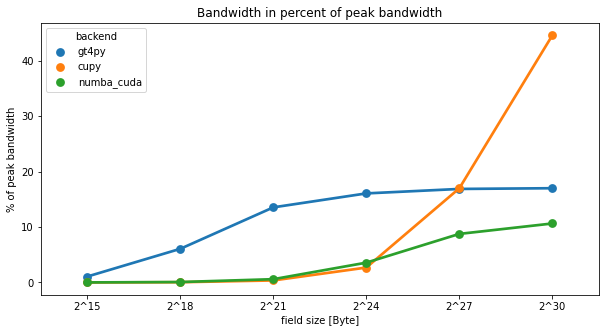

In [23]:
plt.figure(figsize=(10,5))
chart=sns.pointplot(x="number_of_gbytes", y=df_data.fraction_of_peak_bandwidth*100, 
                  hue="backend",
                  data=df_data,ci=False
                 )
chart.set(xlabel='field size [Byte]', ylabel='% of peak bandwidth')
plt.title('Bandwidth in percent of peak bandwidth')
#chart.set_yscale("log")

texts = [t.get_text()  for t in chart.get_xticklabels()]
ticks = []
for i in texts:
    ticks.append("2^" + str(int(np.log2(float(i)*1024**3))))
chart.set_xticklabels(ticks)

### Detailed analysis for data between 1 and 8 GB: 

In [27]:
#Parameter 
field_size_nx = 512
field_size_ny = [512,1024]
field_size_nz = [512, 1024]

df_name = "bandwidth_detailed" #Name of evaluation dataframe
num_iter = 20

#timing
for size_ny in field_size_ny:
    for size_nz in field_size_nz:
        if size_nz >=size_ny: 
            print(field_size_nx,'x', size_ny, 'x', size_nz, ':')
            for y in backend_list:
                bashCommand=f" python3 main_bandwidth.py --nx {field_size_nx} --ny {size_ny} --nz {size_nz} --backend {y} --num_iter {num_iter} --df_name {df_name}"
                process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
                print('                 ',y,' calculated.')
                output, error = process.communicate()
                #print(output.decode("utf-8"))

512 x 512 x 512 :
                  gt4py  calculated.
Total worktime: 1.7221884727478027 s. In 20 iteration(s) the average lapsed time for one run is 0.08610942363739013 +/- 1.1089386093435624e-05 s
data transferred = 1.0 GB
memory bandwidth = 11.61313 GB/s
peak memory bandwidth = 68.3 GB/s
%peak =  0.17003%
New dataframe bandwidth_detailed generated.

                  cupy  calculated.
Total worktime: 0.6409006118774414 s. In 20 iteration(s) the average lapsed time for one run is 0.03204503059387207 +/- 0.09378512648059639 s
data transferred = 1.0 GB
memory bandwidth = 31.20609 GB/s
peak memory bandwidth = 68.3 GB/s
%peak =  0.45690%

                  numba_cuda  calculated.
Total worktime: 2.749093532562256 s. In 20 iteration(s) the average lapsed time for one run is 0.13745467662811278 +/- 0.046814044689177894 s
data transferred = 1.0 GB
memory bandwidth =  7.27513 GB/s
peak memory bandwidth = 68.3 GB/s
%peak =  0.10652%

512 x 512 x 1024 :
                  gt4py  calculated.
To

In [28]:
df_data= pd.read_pickle("eval/{}_result.pkl".format("bandwidth_detailed"))

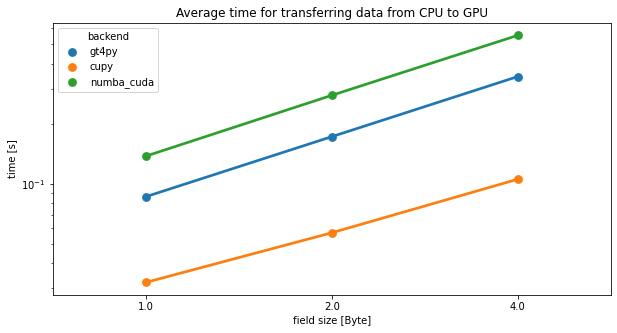

In [29]:
plt.figure(figsize=(10,5))
chart=sns.pointplot(x="number_of_gbytes", y="time_avg", 
                  hue="backend",
                  data=df_data,ci=False
                 )
chart.set(xlabel='field size [Byte]', ylabel='time [s]')
plt.title('Average time for transferring data from CPU to GPU')
chart.set_yscale("log")

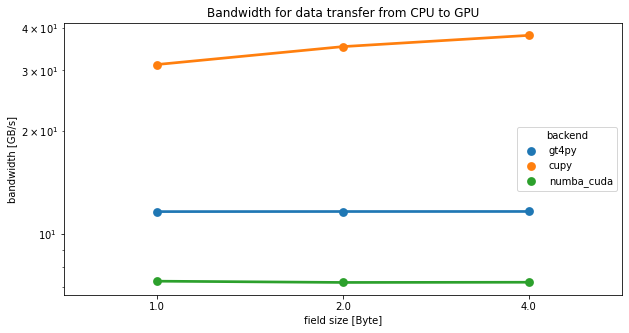

In [30]:
import matplotlib.ticker as ticker
plt.figure(figsize=(10,5))
chart=sns.pointplot(x="number_of_gbytes", y="memory_bandwidth_in_gbs", 
                  hue="backend",
                  data=df_data,ci=False
                 )
chart.set(xlabel='field size [Byte]', ylabel='bandwidth [GB/s]')
plt.title('Bandwidth for data transfer from CPU to GPU')
chart.set_yscale("log")
#chart.set_xscale("log")

Text(0.5, 1.0, 'Bandwidth in percent of peak bandwidth')

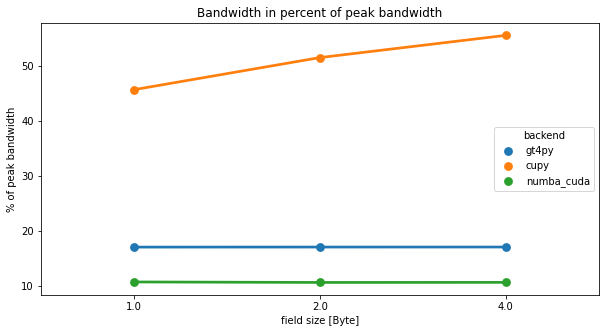

In [31]:
plt.figure(figsize=(10,5))
chart=sns.pointplot(x="number_of_gbytes", y=df_data.fraction_of_peak_bandwidth*100, 
                  hue="backend",
                  data=df_data,ci=False
                 )
chart.set(xlabel='field size [Byte]', ylabel='% of peak bandwidth')
plt.title('Bandwidth in percent of peak bandwidth')
#chart.set_yscale("log")


### diverses:

In [67]:
texts = [t.get_text()  for t in chart.get_xticklabels()]
ticks = []
for i in texts:
    ticks.append('{:.2e}'.format(float(i)))
print(ticks)

['3.05e-05', '2.44e-04', '1.95e-03', '1.56e-02', '1.25e-01', '1.00e+00']
['3.05e-05', '2.44e-04', '1.95e-03', '1.56e-02', '1.25e-01', '1.00e+00']


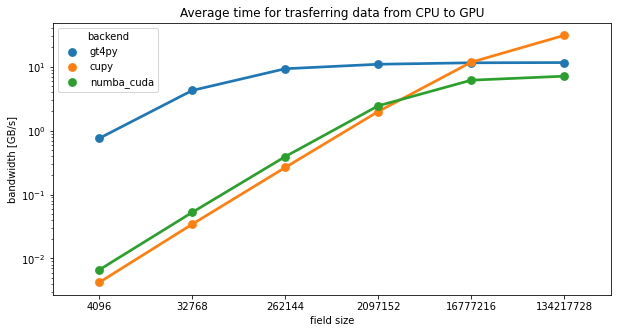

In [97]:
plt.figure(figsize=(10,5))
chart=sns.pointplot(x=df_data.nx*df_data.ny*df_data.nz, y="memory_bandwidth_in_gbs", 
                  hue="backend",
                  data=df_data,ci=False
                 )
chart.set(xlabel='field size', ylabel='bandwidth [GB/s]')
plt.title('Average time for trasferring data from CPU to GPU')
chart.set_yscale("log")
#chart.set_xscale("linear")